In [ ]:
pip install xgboost lightgbm catboost sklego

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [47]:
train = pd.read_csv('train.csv').drop(columns = ['id'])
test = pd.read_csv('test.csv').drop(columns = ['id'])
sub = pd.read_csv('sample_submission.csv')
original = pd.read_csv('original.csv')

train = pd.concat([train, original], axis = 0).reset_index(drop = True)

## Rounding

In [ ]:
new = pd.read_csv('submissions/Ensemble_submission.csv')

In [ ]:
new.head()

In [ ]:
new['Age'] = np.round(new['Age']).astype(int)
new.head()

In [ ]:
new.to_csv('submissions/Ensemble_rounded.csv', index = False)

## Exploratory Data Analysis:

In [ ]:
train.head()

In [37]:
train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000
mean,1.317153,1.024316,0.348154,23.394310,10.109418,5.062290,6.727465,9.967156
std,0.288404,0.237949,0.092723,12.713088,5.652666,2.809131,3.603159,3.177472
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.150000,0.887500,0.287500,13.395139,5.712424,2.849125,3.940580,8.000000
50%,1.375000,1.075000,0.362500,23.728531,9.879801,4.975337,6.874754,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.047177,7.002326,9.086015,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
print(train.isna().sum())
print('\n', test.isna().sum())

In [ ]:
train.drop(columns = ['Sex']).corr()

In [ ]:
train.drop(columns = ['Sex']).corr()

In [ ]:
train.head()

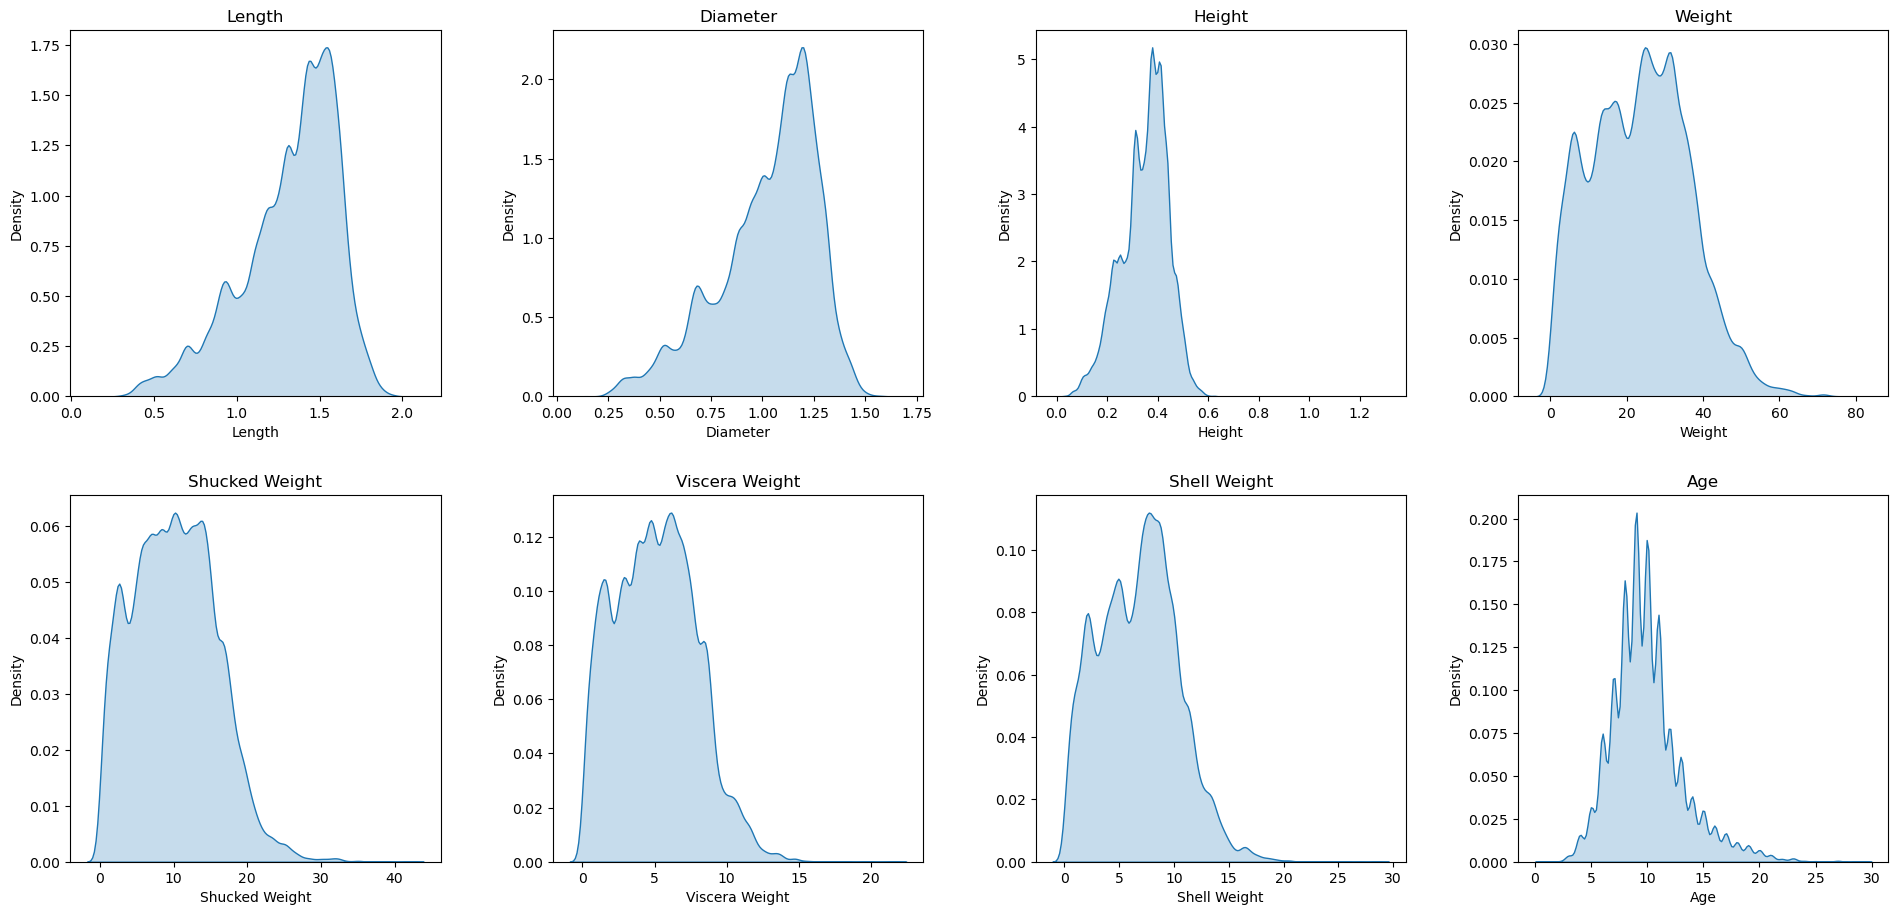

In [39]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
plt.tight_layout(pad = 5)

sns.kdeplot(ax = axes[0, 0], data = train, x = 'Length', fill = True).set_title('Length')
sns.kdeplot(ax = axes[0, 1], data = train, x = 'Diameter', fill = True).set_title('Diameter')
sns.kdeplot(ax = axes[0, 2], data = train, x = 'Height', fill = True).set_title('Height')
sns.kdeplot(ax = axes[0, 3], data = train, x = 'Weight', fill = True).set_title('Weight')
sns.kdeplot(ax = axes[1, 0], data = train, x = 'Shucked Weight', fill = True).set_title('Shucked Weight')
sns.kdeplot(ax = axes[1, 1], data = train, x = 'Viscera Weight', fill = True).set_title('Viscera Weight')
sns.kdeplot(ax = axes[1, 2], data = train, x = 'Shell Weight', fill = True).set_title('Shell Weight')
sns.kdeplot(ax = axes[1, 3], data = train, x = 'Age', fill = True).set_title('Age')
plt.show()

## Feature Engineering and Cleaning:

In [48]:
## Weight
train['Accounted Weight'] = train['Shucked Weight'] + train['Viscera Weight'] + train['Shell Weight']
train['Weight Diff.'] = train['Weight'] - train['Accounted Weight']
train['Too Heavy'] = np.where(train['Accounted Weight'] > train['Weight'], 1, 0)
train['Shucked Weight'] = np.where(train['Accounted Weight'] > train['Weight'], 0.424150 * train['Weight'], train['Shucked Weight'])
train['Viscera Weight'] = np.where(train['Accounted Weight'] > train['Weight'], 0.213569 * train['Weight'], train['Viscera Weight'])
train['Shell Weight'] = np.where(train['Accounted Weight'] > train['Weight'], 0.288712 * train['Weight'], train['Shell Weight'])
train['Shucked Weight Perc.'] = train['Shucked Weight'] / train['Weight']
train['Viscera Weight Perc.'] = train['Viscera Weight'] / train['Weight']
train['Shell Weight Perc.'] = train['Shell Weight'] / train['Weight']

test['Accounted Weight'] = test['Shucked Weight'] + test['Viscera Weight'] + test['Shell Weight']
test['Weight Diff.'] = test['Weight'] - test['Accounted Weight']
test['Too Heavy'] = np.where(test['Accounted Weight'] > test['Weight'], 1, 0)
test['Shucked Weight'] = np.where(test['Accounted Weight'] > test['Weight'], 0.424150 * test['Weight'], test['Shucked Weight'])
test['Viscera Weight'] = np.where(test['Accounted Weight'] > test['Weight'], 0.213569 * test['Weight'], test['Viscera Weight'])
test['Shell Weight'] = np.where(test['Accounted Weight'] > test['Weight'], 0.288712 * test['Weight'], test['Shell Weight'])
test['Shucked Weight Perc.'] = test['Shucked Weight'] / test['Weight']
test['Viscera Weight Perc.'] = test['Viscera Weight'] / test['Weight']
test['Shell Weight Perc.'] = test['Shell Weight'] / test['Weight']

In [49]:
## Dimensions
train['Height'] = np.where(train['Height'] > 2, np.mean(train['Height']), 
                           np.where(train['Height'] == 0, 0.29337*train['Length']-0.03826729, train['Height']))
train['Volume'] = train['Length'] * train['Diameter'] * train['Height']
train['Density'] = train['Weight'] / train['Volume']

test['Height'] = np.where(test['Height'] > 2, np.mean(test['Height']), 
                           np.where(test['Height'] == 0, 0.29400666*test['Length']-0.03933592, test['Height']))
test['Volume'] = test['Length'] * test['Diameter'] * test['Height']
test['Density'] = test['Weight'] / test['Volume']

In [50]:
## Gender
train['Male'] = np.where(train['Sex'] == 'M', 1, 0); train['Female'] = np.where(train['Sex'] == 'F', 1, 0)
test['Male'] = np.where(test['Sex'] == 'M', 1, 0); test['Female'] = np.where(test['Sex'] == 'F', 1, 0)

In [53]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Weight Diff.,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,Volume,Density,Male,Female
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,27.725811,1.247378,0,0.439335,0.229452,0.288160,0.671953,43.117872,0,0
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,10.248344,0.170097,0,0.434014,0.223129,0.326531,0.249563,41.746822,0,0
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,23.558434,1.219029,0,0.457666,0.224256,0.268879,0.578848,42.804808,1,0
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,46.343665,4.316891,0,0.401791,0.216970,0.296027,1.200625,42.195154,0,1
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,22.438629,0.850485,0,0.514303,0.193548,0.255630,0.427148,54.522298,0,0


In [54]:
train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Weight Diff.,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,Volume,Density,Male,Female
count,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000
mean,1.317153,1.024316,0.348107,23.394310,9.991781,5.015528,6.676592,9.967156,21.899173,1.495138,0.116430,0.424150,0.213569,0.288712,0.540308,44.498084,0.365891,0.310928
std,0.288404,0.237949,0.091297,12.713088,5.605022,2.797661,3.596354,3.177472,11.774035,1.714723,0.320742,0.045038,0.025073,0.032700,0.301854,7.463434,0.481682,0.462877
min,0.187500,0.137500,0.012500,0.056699,0.024049,0.012109,0.016370,1.000000,0.085048,-13.834556,0.000000,0.083333,0.042254,0.075472,0.000645,13.761465,0.000000,0.000000
25%,1.150000,0.887500,0.287500,13.395139,5.627438,2.806601,3.827183,8.000000,12.686401,0.382718,0.000000,0.399395,0.199823,0.268395,0.301875,40.714992,0.000000,0.000000
50%,1.375000,1.075000,0.362500,23.728531,9.851451,4.931451,6.803880,10.000000,22.140960,1.133980,0.000000,0.424150,0.213569,0.288712,0.542871,43.761887,0.000000,0.000000
75%,1.537500,1.200000,0.412500,32.162508,13.962129,6.973977,9.071840,11.000000,30.348140,2.253785,0.000000,0.452707,0.227729,0.306196,0.755371,47.242022,1.000000,1.000000
max,2.037500,1.625000,1.287500,80.101512,42.184056,21.545620,28.491248,29.000000,76.331029,25.500375,1.000000,0.602740,0.444444,0.494845,3.205271,463.780432,1.000000,1.000000


In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
plt.tight_layout(pad = 5)

sns.kdeplot(ax = axes[0, 0], data = train, x = 'Volume', fill = True).set_title('Volume')
sns.kdeplot(ax = axes[0, 1], data = train, x = 'Density', fill = True).set_title('Density')
sns.kdeplot(ax = axes[0, 2], data = train, x = 'Shucked Weight Perc.', fill = True).set_title('Shucked Weight Perc.')
sns.kdeplot(ax = axes[0, 3], data = train, x = 'Viscera Weight Perc.', fill = True).set_title('Viscera Weight Perc.')
sns.kdeplot(ax = axes[1, 0], data = train, x = 'Shell Weight Perc.', fill = True).set_title('Shell Weight Perc')
plt.show()

In [ ]:
numeric_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 
                    'Shell Weight', 'Shucked Weight Perc.', 'Viscera Weight Perc.', 'Shell Weight Perc.']

scaler = StandardScaler().fit(train[numeric_features])
X_train = scaler.transform(train[numeric_features])
X_test = scaler.transform(test[numeric_features])

pca = PCA(0.9).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = pd.DataFrame(X_train_pca, columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4'])
X_test_pca = pd.DataFrame(X_test_pca, columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4'])

train = pd.concat([train, X_train_pca], axis = 1)
test = pd.concat([test, X_test_pca], axis = 1)

In [ ]:
# grouped = train.groupby('Sex')['Shucked Weight'].agg([np.min, np.max, np.median, np.mean]).reset_index()
# grouped.columns = ['Sex','min_price_by_pos', 'max_price_by_pos','median_price_by_pos','mean_price_by_pos']

# ## Adding aggregated price info
# full_data = pd.merge(full_data, price_by_pos, how = 'left', on = 'pos')

## Hyper-parameter Tuning:

## Modelling:

In [ ]:
xgb_params = {'n_estimators': 1000, 
              'learning_rate': 0.00482382842096919, 
              'booster': 'gbtree', 
              'lambda': 0.000235366507474591, 
              'alpha': 0.0000115977765684837, 
              'subsample': 0.35955930593108, 
              'colsample_bytree': 0.898528184386095, 
              'max_depth': 9, 
              'min_child_weight': 8, 
              'eta': 0.0000784943239744148, 
              'gamma': 1.6661346939401E-07, 
              'grow_policy': 'lossguide', 
              'n_jobs': -1, 
              'objective': 'reg:squarederror',
              'eval_metric': 'mae', 
              'verbosity': 0}

lgb1_params = {'n_estimators': 1000,
               'learning_rate': 0.00659605502010782,
               "reg_alpha": 0.0134568843414818,
               "reg_lambda": 2.38367559632979E-06,
               "num_leaves": 117,
               "colsample_bytree": 0.850706320762174,
               'subsample': 0.691827302225948,
               'subsample_freq': 4,
               'min_child_samples': 33,
               'objective': 'regression_l2',
               'metric': 'mae',
               'boosting_type': 'gbdt'}

cat1_params = {'iterations': 1000,
               'depth': 7,
               'learning_rate': 0.00454306521731278,
               'l2_leaf_reg': 0.113774158297261,
               'random_strength': 0.0179641854849499,
               'od_type': 'IncToDec',
               'od_wait': 50,
               'bootstrap_type': 'Bayesian',
               'grow_policy': 'Lossguide',
               'bagging_temperature': 1.39240858193441,
               'eval_metric': 'MAE',
               'loss_function': 'MAE',
               'verbose': False,
               'allow_writing_files': False}

hist_params = {'loss': 'absolute_error',
               'l2_regularization': 0.0104104133357932,
               'early_stopping': True,
               'learning_rate': 0.00627298859709192,
               'max_iter': 1000,
               'n_iter_no_change': 200,
               'max_depth': 16,
               'max_bins': 255,
               'min_samples_leaf': 54,
               'max_leaf_nodes':57}

gbd_params = {'loss': 'absolute_error',
              'n_estimators': 800,
              'max_depth': 10,
              'learning_rate': 0.01,
              'min_samples_split': 10,
              'min_samples_leaf': 20}

models = {"xgb": XGBRegressor(**xgb_params),
          "lgb": LGBMRegressor(**lgb1_params),
          "cat": CatBoostRegressor(**cat1_params),
          'hgb': HistGradientBoostingRegressor(**hist_params),
          "SVR_rbf": SVR(kernel="rbf", gamma="auto"),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=500, n_jobs=-1),
          "GradientBoostingRegressor": GradientBoostingRegressor(**gbd_params)}

In [ ]:
models

In [ ]:
## Dropping some variables
train.drop(columns = ['Sex'], axis = 1, inplace = True)
test.drop(columns = ['id', 'Sex'], axis = 1, inplace = True)

## Defining the input and target variables
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

## Defining lists to store results
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

## Performing KFold cross-validation
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
        
    gb_md = GradientBoostingRegressor(loss = 'absolute_error', n_estimators = 1000, max_depth = 8, learning_rate = 0.01,
                                      min_samples_split = 10, min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test)
    
    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)
    
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error', l2_regularization = 0.01, early_stopping = False, learning_rate = 0.01,
                                            max_iter = 1000, max_depth = 15, max_bins = 255, min_samples_leaf = 30, 
                                            max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMRegressor(objective = 'mae', n_estimators = 1000, max_depth = 10, learning_rate = 0.01, num_leaves = 70, reg_alpha = 3,
                           reg_lambda = 3, subsample = 0.7, colsample_bytree = 0.7).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
        
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror', colsample_bytree = 0.7, gamma = 0.8, learning_rate = 0.01, max_depth = 8, 
                          min_child_weight = 20, n_estimators = 1000, subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'GBC':gb_pred_1,  'hist': hist_pred_1, 'lgb': lgb_pred_1, 'xgb': xgb_pred_1})
    y = Y_test[X_test['generated'] == 1]
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    
    x_test = pd.DataFrame({'GBC':gb_pred_2,  'hist': hist_pred_2, 'lgb': lgb_pred_2, 'xgb': xgb_pred_2})
    lad_pred_test = lad_md.predict(x_test)
        
    ens_score = mean_absolute_error(y, lad_pred)
    ens_cv_scores.append(ens_score)
    ens_preds.append(lad_pred_test)
    
    print('Fold', i, '==> LAD ensemble oof MAE is ==>', ens_score)

In [ ]:
print(np.mean(gb_cv_scores))
print(np.mean(hist_cv_scores))
print(np.mean(lgb_cv_scores))
print(np.mean(xgb_cv_scores))
print(np.mean(ens_cv_scores))

In [ ]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

sub['Age'] = gb_preds_test
sub.to_csv('submissions/GB_submission.csv', index = False)

sub['Age'] = hist_preds_test
sub.to_csv('submissions/Hist_submission.csv', index = False)

sub['Age'] = lgb_preds_test
sub.to_csv('submissions/LightGBM_submission.csv', index = False)

sub['Age'] = xgb_preds_test
sub.to_csv('submissions/XGBoost_submission.csv', index = False)

sub['Age'] = ens_preds_test
sub.to_csv('submissions/Ensemble_submission.csv', index = False)